<a href="https://colab.research.google.com/github/louisapraszezynki/yolo-finetuned/blob/main/yolo-finetuned-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
from datasets import load_dataset

dataset = load_dataset("agyaatcoder/PlantDoc")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/73.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2342 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/236 [00:00<?, ? examples/s]

In [3]:
#!/usr/bin/env python
"""
Convert the Hugging Face object-detection dataset `agyaatcoder/PlantDoc`
to the Ultralytics-YOLO format.

> pip install "datasets[pandas]" pillow tqdm pyyaml
"""

from pathlib import Path
import logging, yaml
from tqdm.auto import tqdm
from datasets import load_dataset
from PIL import Image

# ------------------------------------------------------------------------------
# Config -----------------------------------------------------------------------
# ------------------------------------------------------------------------------
HF_DATASET   = "agyaatcoder/PlantDoc"
SPLIT_MAP    = {"train": "train", "val": "test"}        # HF → YOLO names
OUT_ROOT     = Path("yolo_plantdoc")                    # output root
IMG_DIR      = OUT_ROOT / "images"
LBL_DIR      = OUT_ROOT / "labels"
IMG_SUFFIX   = ".jpg"                                   # keep it simple: JPEG
LOG_LEVEL    = "INFO"

# ------------------------------------------------------------------------------
# Setup ------------------------------------------------------------------------
# ------------------------------------------------------------------------------
logging.basicConfig(format="%(levelname)s: %(message)s", level=LOG_LEVEL)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
(IMG_DIR / "train").mkdir(parents=True, exist_ok=True)
(IMG_DIR / "val").mkdir(parents=True, exist_ok=True)
(LBL_DIR / "train").mkdir(parents=True, exist_ok=True)
(LBL_DIR / "val").mkdir(parents=True, exist_ok=True)

logging.info("🔄 Loading dataset %s ...", HF_DATASET)
ds = load_dataset(HF_DATASET, split=None)  # returns a DatasetDict
logging.info("✅ Loaded: %d train, %d test", len(ds["train"]), len(ds["test"]))

# ------------------------------------------------------------------------------
# Identify the category column inside `objects`
# ------------------------------------------------------------------------------
obj_feat   = ds["train"].features["objects"]            # dict nested feature
POSSIBLE   = ("category", "category_id", "label", "labels", "name")
cat_column = next((k for k in POSSIBLE if k in obj_feat), None)
if cat_column is None:
    raise ValueError(f"No category column found. Keys present: {list(obj_feat)}")
logging.info("🗂  Using '%s' as the label field.", cat_column)

# ------------------------------------------------------------------------------
# Build class list (stable, sorted order) --------------------------------------
# ------------------------------------------------------------------------------
labels = sorted(
    {lbl for split in ds.values() for ex in split for lbl in ex["objects"][cat_column]}
)
name2id = {n: i for i, n in enumerate(labels)}
logging.info("📊 Found %d unique classes.", len(labels))

# ------------------------------------------------------------------------------
# Helper to export one example -------------------------------------------------
# ------------------------------------------------------------------------------
def export_example(split: str, idx: int, ex: dict):
    pil = ex["image"]  # PIL.Image
    if pil.mode not in ("RGB", "L"):          # handle RGBA / CMYK / P
        pil = pil.convert("RGB")
    elif pil.mode == "L":                     # grayscale → 3-channel
        pil = pil.convert("RGB")

    w, h   = pil.size
    stem   = f"{idx:07d}"
    img_p  = IMG_DIR / split / (stem + IMG_SUFFIX)
    lbl_p  = LBL_DIR / split / (stem + ".txt")

    pil.save(img_p, format="JPEG", quality=90)

    lines = []
    for bbox, lbl in zip(ex["objects"]["bbox"], ex["objects"][cat_column]):
        x0, y0, bw, bh = bbox                       # HF format: xywh in **pixels**
        xc, yc = x0 + bw / 2, y0 + bh / 2
        lines.append(
            f"{name2id[lbl]} {xc / w:.6f} {yc / h:.6f} {bw / w:.6f} {bh / h:.6f}"
        )

    if lines:                                      # YOLO spec: no file = no objects
        lbl_p.write_text("\n".join(lines))

# ------------------------------------------------------------------------------
# Export loops with progress bars ----------------------------------------------
# ------------------------------------------------------------------------------
for split, hf_split in SPLIT_MAP.items():
    logging.info("🚚 Exporting %s split ...", split)
    for i, ex in enumerate(
        tqdm(ds[hf_split], total=len(ds[hf_split]), desc=f"{split:5}")
    ):
        export_example(split, i, ex)

# ------------------------------------------------------------------------------
# Write the dataset YAML -------------------------------------------------------
# ------------------------------------------------------------------------------
yaml_dict = {
    "path": str(OUT_ROOT),
    "train": "images/train",
    "val": "images/val",
    "names": {i: n for i, n in enumerate(labels)},
}
with open(OUT_ROOT / "dataset.yaml", "w") as f:
    yaml.safe_dump(yaml_dict, f, sort_keys=False)

logging.info("🎉 All done!  →  %s", OUT_ROOT / "dataset.yaml")


train:   0%|          | 0/2342 [00:00<?, ?it/s]

val  :   0%|          | 0/236 [00:00<?, ?it/s]

In [4]:
!yolo detect train data=/content/yolo_plantdoc/dataset.yaml model=yolov8n.pt epochs=60

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_plantdoc/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, ko

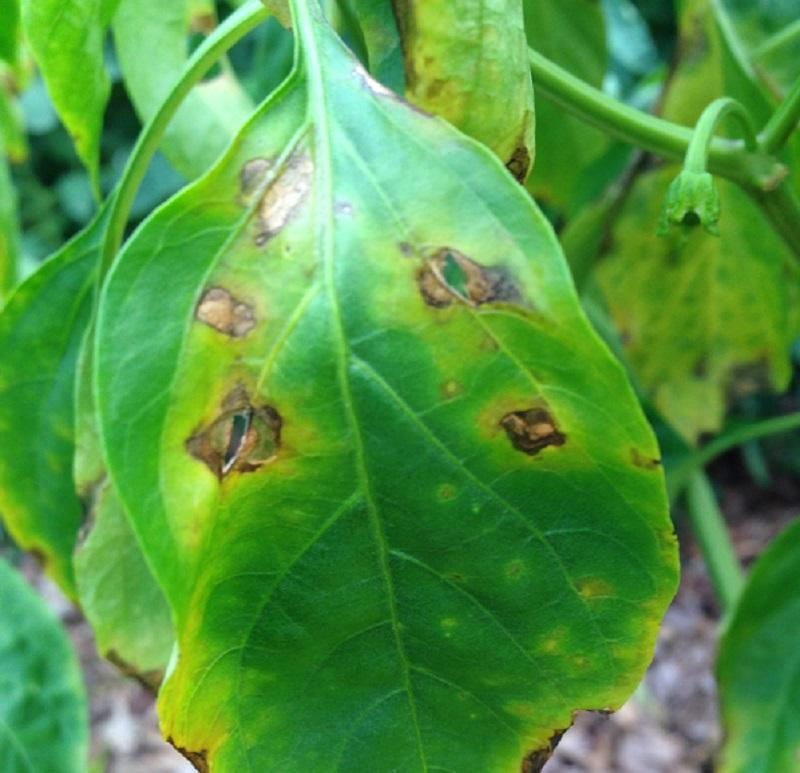

In [5]:
from PIL import Image
import requests
from io import BytesIO

url = "https://extension.umd.edu/sites/extension.umd.edu/files/styles/optimized/public/2021-05/hgic_veg_bacterial%20leaf%20spot_pepper_800.jpg?itok=0snxoX9B"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)


0: 640x640 1 Bell_pepper leaf spot, 14.6ms
Speed: 9.1ms preprocess, 14.6ms inference, 145.7ms postprocess per image at shape (1, 3, 640, 640)


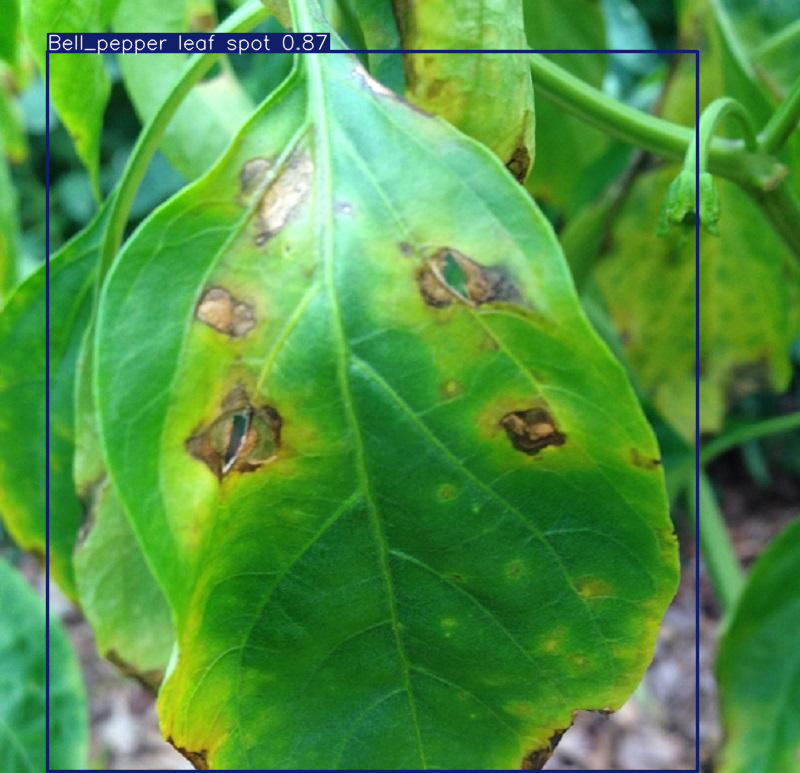

In [6]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
results = model(img)
results[0].show()

In [8]:
! hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
The token `write` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when push

In [9]:
! hf upload Louloubib/yolov8n-finetuned ./runs/detect/train/weights/best.pt yolov8n.pt

best.pt: 100% 6.24M/6.24M [00:00<00:00, 6.86MB/s]
https://huggingface.co/Louloubib/yolov8n-finetuned/blob/main/yolov8n.pt
